In [1]:
__author__ = 'Yumi Choi <yumi.choi@noirlab.edu>'
__version__ = '20230918' 
__datasets__ = ['phat_v2']  
__keywords__ = ['M31', 'stars', 'interactive plot', 'plot:cmd', 'plot:sed']

# Exploring Resolved Stellar Populations in M31 with PHAT

*Yumi Choi & the Astro Data Lab Team*

### Table of contents
* [Goals & notebook summary](#goals)
* [Disclaimer & attribution](#attribution)
* [Imports & setup](#import)
* [Authentication](#auth)
* [First chapter](#chapter1)
* [Resources and references](#resources)

<a class="anchor" id="goals"></a>
# Goals
One or two sentences, or a bullet list, of the goals of this notebook. E.g. "To find dwarf galaxies in DES DR1 images".

# Summary
Description of the content of this notebook: we do X, using data Y. The technique used is Z. Also rename the notebook file to something meaningful, e.g. 'TimeSeriesAnalysisRRLyrae_20171011'.

<a class="anchor" id="attribution"></a>
# Disclaimer & attribution
If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445

* Data Lab disclaimer: https://datalab.noirlab.edu/disclaimers.php

<a class="anchor" id="import"></a>
# Imports and setup

In [21]:
# std lib
from getpass import getpass

# 3rd party # remove imports that are not needed
import numpy as np
import pylab as plt
import matplotlib
import healpy as hp

# Data Lab
from dl import authClient as ac, queryClient as qc, storeClient as sc
from dl.helpers.utils import convert

# Explore the main PHAT object table
The notebook `M31withPhat` listed available tables in the PHAT databse. This notebook will use the main PHAT object table, phat_v2.phot_mod, which contains combined average photometry.

### Examine the columns of the phat_v2.phot_mod table

First, query 10 rows from phat_v2.phot_mod just to get all columns.

In [13]:
query = """SELECT *
           FROM phat_v2.phot_mod
           LIMIT 10
        """

In [14]:
try:
    result = qc.query(sql=query) # by default the result is a CSV formatted string
except Exception as e:
    print(e.message)

### Convert the output to a Pandas Dataframe
Convert the result, which is by default a CSV formatted string, to a Pandas dataframe.

In [12]:
df1 = convert(result,'pandas')
print("Number of columns:",len(df1.columns))
print(df1.columns)

Number of columns: 88
Index(['ra', 'dec', 'htm9', 'pix256', 'pix4096', 'random_id', 'x', 'y', 'ir_x',
       'ir_y', 'f110w_rate', 'f110w_raterr', 'f110w_vega', 'f110w_err',
       'f110w_chi', 'f110w_snr', 'f110w_sharp', 'f110w_round', 'f110w_crowd',
       'f160w_rate', 'f160w_raterr', 'f160w_vega', 'f160w_err', 'f160w_chi',
       'f160w_snr', 'f160w_sharp', 'f160w_round', 'f160w_crowd', 'f275w_rate',
       'f275w_raterr', 'f275w_vega', 'f275w_err', 'f275w_chi', 'f275w_snr',
       'f275w_sharp', 'f275w_round', 'f275w_crowd', 'f336w_rate',
       'f336w_raterr', 'f336w_vega', 'f336w_err', 'f336w_chi', 'f336w_snr',
       'f336w_sharp', 'f336w_round', 'f336w_crowd', 'f475w_rate',
       'f475w_raterr', 'f475w_vega', 'f475w_err', 'f475w_chi', 'f475w_snr',
       'f475w_sharp', 'f475w_round', 'f475w_crowd', 'f814w_rate',
       'f814w_raterr', 'f814w_vega', 'f814w_err', 'f814w_chi', 'f814w_snr',
       'f814w_sharp', 'f814w_round', 'f814w_crowd', 'f814w_f475w',
       'f475w_f336w', '

<a class="anchor" id="chapter1"></a>
# Make a Healpix map of the brick number

PHAT tiled the survey area with 23 bricks. Each brick consists of a 3$\times$6 mosaic of 18 HST pointings.

One of the columns in the PHAT object table, pix4096, is the Healpix index (NSIDE=4096, nested scheme) for the objects's RA and Dec. Healpix is a handy tesselation of the sky into tiles of equal area. To make maps of aggregate quantities in PHAT, we're going to use the database to return results in a query grouped by Healpix index value.  We can then put the results into arrays, and use `healpy`'s functionality to display the maps.

In this first query, the GROUP BY clause tells the database to aggregate the results by the values in the pix4096 column, and return the average RA and Dec of objects in those groups, as well as the pix4096 value itself and the count of the number of objects in the group.

In [125]:
query = """SELECT avg(ra) as ra0, avg(dec) as dec0, pix4096, count(pix4096) as nb, 
            avg(brick) as brick
           FROM phat_v2.phot_mod
           WHERE f475w_gst=1 AND f814w_gst=1 AND 
            f475w_vega-f814w_vega>-0.5 AND f475w_vega-f814w_vega<0.25 AND f814w_vega<24
           GROUP BY pix4096
          """

In [126]:
try:
    result = qc.query(sql=query) # by default the result is a CSV formatted string
except Exception as e:
    print(e.message)

In [127]:
df_MS = convert(result,'pandas')
print("Number of rows:", len(df_MS))

Number of rows: 2511


In [128]:
(rarot,decrot)=(np.median(df_MS['ra0']),np.median(df_MS['dec0']))

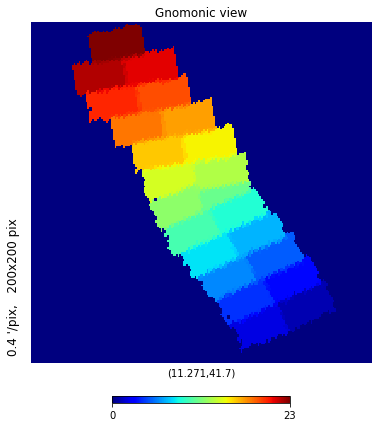

In [129]:
brickmap = np.zeros(hp.nside2npix(4096))
brickmap[df_MS['pix4096']] = df_MS['brick']
hp.gnomview(brickmap,reso=0.4,nest=True,rot=(rarot,decrot,0),cmap='jet',min=0,max=23)

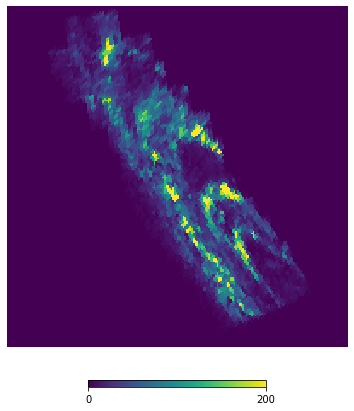

In [132]:
msmap = np.zeros(hp.nside2npix(4096))
msmap[df_MS['pix4096']] = df_MS['nb']
hp.gnomview(msmap, title='', notext=True, reso=0.4, nest=True, 
            rot=(rarot,decrot,0), norm="%LogNorm", max=200)

### RGB spatial distribution

In [135]:
query = """SELECT pix4096, count(pix4096) as nb
           FROM phat_v2.phot_mod
           WHERE f110w_gst=1 AND f160w_gst=1 AND 
            f110w_vega-f160w_vega>0.75 AND f110w_vega-f160w_vega<2.0 AND 
            f160w_vega>18.5 AND f160w_vega<22.0
           GROUP BY pix4096
          """

In [136]:
try:
    result = qc.query(sql=query) # by default the result is a CSV formatted string
except Exception as e:
    print(e.message)

In [137]:
df_RGB = convert(result,'pandas')
print("Number of rows:", len(df_RGB))

Number of rows: 2571


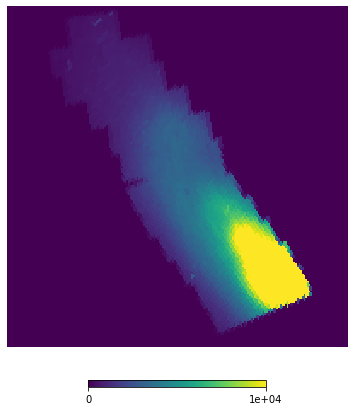

In [140]:
rgbmap = np.zeros(hp.nside2npix(4096))
rgbmap[df_RGB['pix4096']] = df_RGB['nb']
hp.gnomview(rgbmap, title='', notext=True, reso=0.4, nest=True, 
            rot=(rarot,decrot,0), norm="%LogNorm", max=1e4)

<a class="anchor" id="resources"></a>
# Resources and references
Dalcanton, J.J. et al. (2012, ApJS, 200, 18), "The Panchromatic Hubble Andromeda Treasury"
http://adsabs.harvard.edu/abs/2012ApJS..200...18D

Williams, B.F. et al. (2023, arXiv:2307.09681), "The Panchromatic Hubble Andromeda Treasury XXI. The Legacy Resolved Stellar Photometry Catalog"
https://ui.adsabs.harvard.edu/abs/2023arXiv230709681W/abstract